# Investing in 2018 Real Estate

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import statsmodels.api as sm
import pandas.tseries
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import itertools
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

df = pd.read_csv('zillow_data.csv')

In [ ]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [ ]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':['mean','std']})

In [2]:
#importing data on US 10 year treasury rates i.e. risk free rate
rfr = pd.read_csv('DGS10.csv')

In [3]:
rfr.DATE = pd.to_datetime(rfr.DATE,infer_datetime_format=True)
rfr = rfr.set_index('DATE')
rfr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5848 entries, 1996-01-02 to 2018-05-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DGS10   5848 non-null   object
dtypes: object(1)
memory usage: 91.4+ KB


In [4]:
#cleaing this for string issues and converting to float, also resampling from daily to monthly ts
#and trimming to fit our dataset
rfr = rfr[rfr.DGS10 != '.']
rfr.DGS10 = rfr.DGS10.apply(lambda x: np.float(x))
rfr = rfr.resample('MS',).mean()
rfr = rfr[3:-1]
rfr.DGS10 = rfr.DGS10/100

In [5]:
rfr

,DGS10
DATE,
1996-04-01,0.065114
1996-05-01,0.067368
1996-06-01,0.069120
1996-07-01,0.068655
1996-08-01,0.066355
...,...
2017-12-01,0.024025
2018-01-01,0.025838
2018-02-01,0.028589


In [6]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Data columns (total 272 columns):
 #   Column      Dtype  
---  ------      -----  
 0   RegionID    int64  
 1   RegionName  int64  
 2   City        object 
 3   State       object 
 4   Metro       object 
 5   CountyName  object 
 6   SizeRank    int64  
 7   1996-04     float64
 8   1996-05     float64
 9   1996-06     float64
 10  1996-07     float64
 11  1996-08     float64
 12  1996-09     float64
 13  1996-10     float64
 14  1996-11     float64
 15  1996-12     float64
 16  1997-01     float64
 17  1997-02     float64
 18  1997-03     float64
 19  1997-04     float64
 20  1997-05     float64
 21  1997-06     float64
 22  1997-07     float64
 23  1997-08     float64
 24  1997-09     float64
 25  1997-10     float64
 26  1997-11     float64
 27  1997-12     float64
 28  1998-01     float64
 29  1998-02     float64
 30  1998-03     float64
 31  1998-04     float64
 32  1998-05     float64
 33  1998-06   

In [7]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


Seeing that we have wide format for home price values with all details in leftside columns I will group through different subcategories to eventually narrow down top 5 zipcodes

### Exploring States

In [8]:
#Firstly grouping into states to see which states to pull counties for
states = df.drop(columns=['RegionID','RegionName', 'City', 'Metro', 'CountyName','SizeRank'],axis=1).groupby('State').mean()
states = pd.DataFrame(states.reset_index())
state_columns = list(states.T.iloc[0])
states = states.T
states.columns = state_columns
states = states[1:]
states = states.set_index(pd.to_datetime(states.index))
states = states.applymap(lambda x: round(np.float(x),2))

In [9]:
states

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
1996-04-01,128382.14,86795.57,68868.04,116202.79,200220.96,142561.94,157189.52,189216.67,125784.62,104529.02,...,54320.00,66087.47,109384.64,159645.69,122071.24,82825.00,140589.29,115151.38,66461.67,138712.50
1996-05-01,128832.14,87122.15,69015.46,116562.79,200124.83,142765.99,157063.71,188611.11,126234.62,104594.12,...,54640.00,66340.85,109406.89,159523.28,122136.83,82556.25,140838.99,115099.39,66575.00,138762.50
1996-06-01,129253.57,87460.76,69140.21,116934.88,200035.94,142985.43,156926.61,188011.11,126665.38,104662.35,...,54960.00,66594.99,109451.38,159406.90,122201.08,82306.25,141101.49,115032.11,66708.33,138741.67
1996-07-01,129639.29,87798.73,69262.89,117315.35,199965.57,143204.45,156778.23,187438.89,127026.92,104727.06,...,55290.00,66843.11,109521.50,159313.79,122267.20,82037.50,141378.57,114940.67,66848.33,138641.67
1996-08-01,130028.57,88156.96,69378.35,117719.53,199958.75,143461.94,156640.32,186900.00,127346.15,104816.99,...,55660.00,67081.70,109613.98,159254.31,122352.42,81781.25,141686.01,114840.98,67016.67,138533.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,322657.14,151629.51,133188.57,265908.26,723263.48,396777.51,282175.81,790450.00,274487.80,280250.96,...,188426.32,146519.31,193761.27,307212.40,280219.70,216318.75,394339.59,195418.07,124022.22,227525.81
2018-01-01,323775.00,152402.73,133522.86,267327.83,729496.41,399905.22,282852.42,793622.22,277912.20,281561.40,...,189621.05,147265.84,194417.49,309129.75,280901.00,214750.00,398688.56,196397.89,124104.17,228564.52
2018-02-01,324167.86,153625.68,134456.19,268714.78,735525.98,403134.94,283826.61,798838.89,279470.73,283416.18,...,191110.53,148351.98,195503.13,311445.45,282143.64,213581.25,402129.91,197306.02,124334.72,229938.71
2018-03-01,323692.86,155504.37,136192.38,270488.70,742146.32,407292.37,284893.55,804600.00,276529.27,286090.83,...,193236.84,150242.08,197023.36,314685.95,284158.35,213250.00,405867.16,198282.23,124972.22,230996.77


In [10]:
## converting index to datetime for plotting
states.index = pd.to_datetime(states.index,format='%Y-%M')
states.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

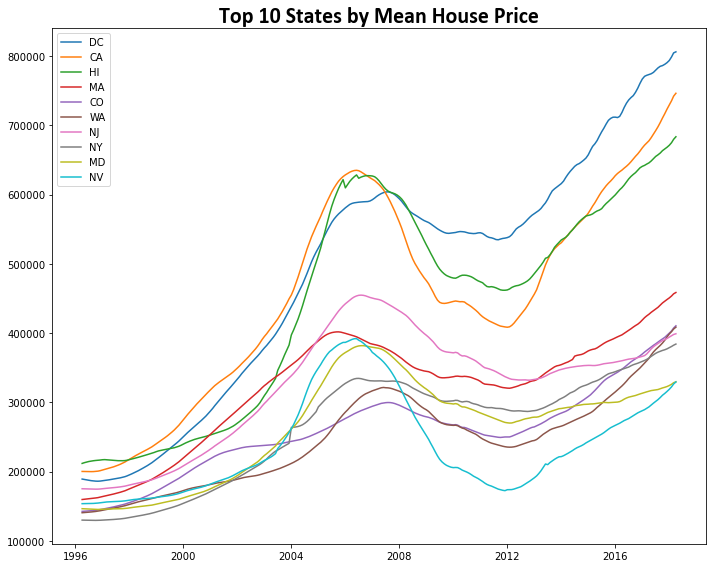

In [11]:
## Exploring top 10 states by highest mean home price in 2018
top10states = list(states.iloc[-1,:].sort_values(ascending=False).head(10).index)
font = {'family' : 'Calibri',
        'weight' : 'bold',
        'size'   : 22}
rcParams['figure.figsize'] = 10,8
sns.lineplot(data=states[top10states],dashes=False)
plt.title('Top 10 States by Mean House Price',font=font)
plt.tight_layout()

In [12]:
state_list = list(states.columns)

In [13]:
##creating a list of dfs per state
state_dfs = []
for x in state_list:
    x = pd.DataFrame(data = states[x],)
    state_dfs.append(x)

In [14]:
#checking
state_dfs

[                   AK
 1996-04-01  128382.14
 1996-05-01  128832.14
 1996-06-01  129253.57
 1996-07-01  129639.29
 1996-08-01  130028.57
 ...               ...
 2017-12-01  322657.14
 2018-01-01  323775.00
 2018-02-01  324167.86
 2018-03-01  323692.86
 2018-04-01  323046.43
 
 [265 rows x 1 columns],
                    AL
 1996-04-01   86795.57
 1996-05-01   87122.15
 1996-06-01   87460.76
 1996-07-01   87798.73
 1996-08-01   88156.96
 ...               ...
 2017-12-01  151629.51
 2018-01-01  152402.73
 2018-02-01  153625.68
 2018-03-01  155504.37
 2018-04-01  157033.88
 
 [265 rows x 1 columns],
                    AR
 1996-04-01   68868.04
 1996-05-01   69015.46
 1996-06-01   69140.21
 1996-07-01   69262.89
 1996-08-01   69378.35
 ...               ...
 2017-12-01  133188.57
 2018-01-01  133522.86
 2018-02-01  134456.19
 2018-03-01  136192.38
 2018-04-01  137620.00
 
 [265 rows x 1 columns],
                    AZ
 1996-04-01  116202.79
 1996-05-01  116562.79
 1996-06-01  116934.88

In [15]:
#for each state df creating ROI YoY and MoM EMA for mean and std and creating sharpe ratio for monthly and annual periods
for state_df in state_dfs:
    state_df['ROI_MoM'] = np.zeros((265))
    state_df['ROI_YoY'] = np.zeros((265))
    for x in range(0,265):    
        if x + 1 <265:
            state_df.iloc[x+1,1] = round((state_df.iloc[x+1,0] - state_df.iloc[x,0])/state_df.iloc[x,0],4)
        else: break
    for x in range(0,265):    
        if x + 12 <265:
            state_df.iloc[x+12,2] = round((state_df.iloc[x+12,0] - state_df.iloc[x,0])/state_df.iloc[x,0],4)
        else: break
    state_df['EMA_6MO_roi_mo'] = state_df.ROI_MoM.ewm(span=6,adjust=False).mean()
    state_df['EMA_6MO_std_mo'] = state_df.ROI_MoM.ewm(span=6,adjust=False).std()
    state_df['EMA_6MO_roi_y'] = state_df.ROI_YoY.ewm(span=6,adjust=False).mean()
    state_df['EMA_6MO_std_y'] = state_df.ROI_YoY.ewm(span=6,adjust=False).std()
    state_df['rfr'] = rfr.DGS10
    state_df['sharpe_ratio_monthly'] = (state_df['EMA_6MO_roi_mo'] - (state_df.rfr/12))/state_df['EMA_6MO_std_mo']
    state_df['sharpe_ratio_annual'] = (state_df['EMA_6MO_roi_y'] - (state_df.rfr))/state_df['EMA_6MO_std_y']

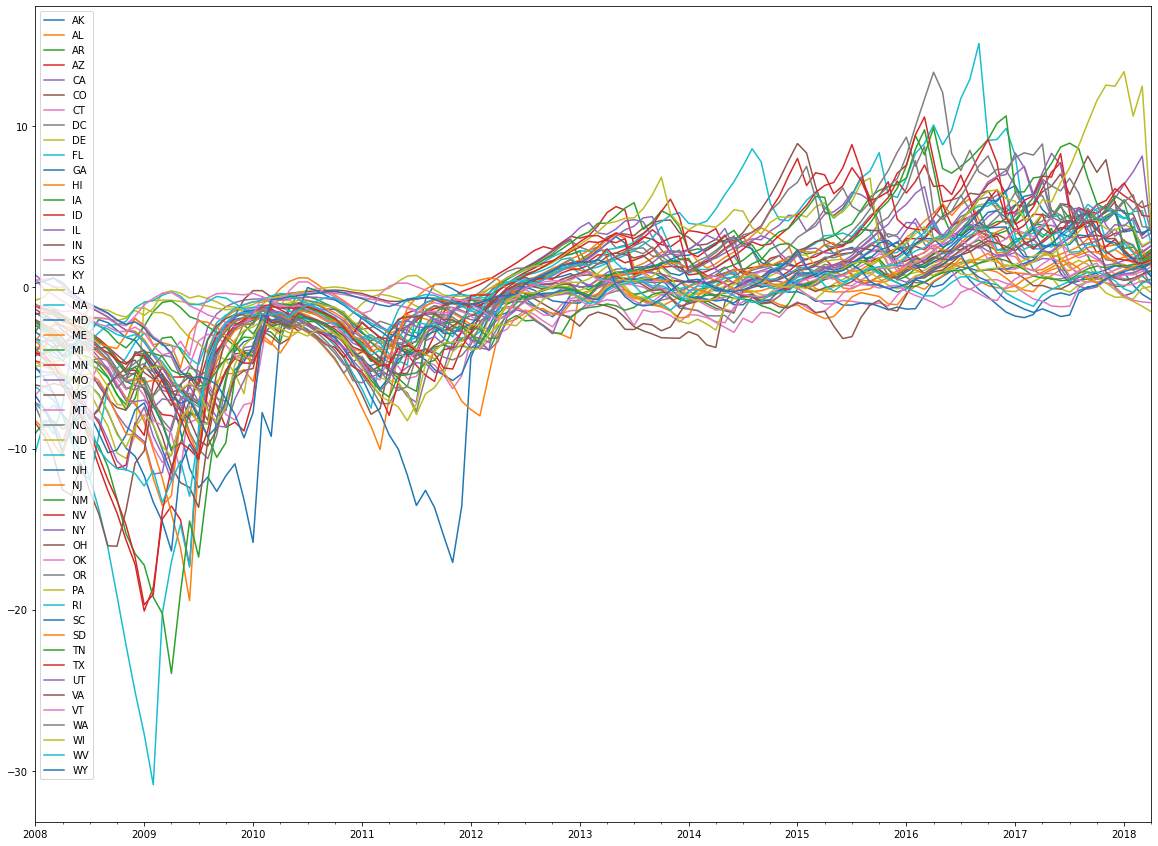

In [16]:
## plotting to see if all went through
fig, ax = plt.subplots(figsize=(20,15))
for state_df in state_dfs:
    state_df['2008':'2018'].sharpe_ratio_monthly.plot(label =state_df.columns[0], ax=ax)
plt.legend(loc=2)

In [17]:
#creating a table of averages for preceding 1, 3, 5, and 10 year periods 
st = []
average_5 = []
average_10 = []
avg_10_y = []
avg_5_y= []
avg_1_mo =[]
avg_1_y=[]
avg_3_mo =[]
avg_3_y=[]
for state in state_dfs:
    st.append(state.columns[0])
    avg_1_mo.append(state['2017-04-01':].sharpe_ratio_monthly.mean())
    avg_1_y.append(state['2017-04-01':].sharpe_ratio_annual.mean())
    average_5.append(state['2013':'2018'].sharpe_ratio_monthly.mean())
    average_10.append(state['2008':'2018'].sharpe_ratio_monthly.mean())
    avg_5_y.append(state['2013':'2018'].sharpe_ratio_annual.mean())
    avg_10_y.append(state['2008':'2018'].sharpe_ratio_annual.mean())
    avg_3_mo.append(state['2015-04-01':].sharpe_ratio_monthly.mean())
    avg_3_y.append(state['2015-04-01':].sharpe_ratio_annual.mean())

state_averages = pd.concat([pd.DataFrame(st,dtype='str'),pd.DataFrame(avg_1_mo,dtype=float),pd.DataFrame(avg_1_y,dtype=float),
                            pd.DataFrame(avg_3_mo,dtype=float),pd.DataFrame(avg_3_y,dtype=float),
                            pd.DataFrame(average_5,dtype=float),pd.DataFrame(avg_5_y,dtype=float),
                                pd.DataFrame(average_10,dtype=float),pd.DataFrame(avg_10_y,dtype=float)],axis=1)
state_averages.columns = ['state','1yr_average_mo','1yr_average_y',
                          '3yr_average_mo','3yr_average_y',
                          '5yr_average_mo','5yr_average_y',
                          '10yr_average_mo','10yr_average_y']

Text(0, 0.5, '10 Year Average Sharpe Ratio (annual)')

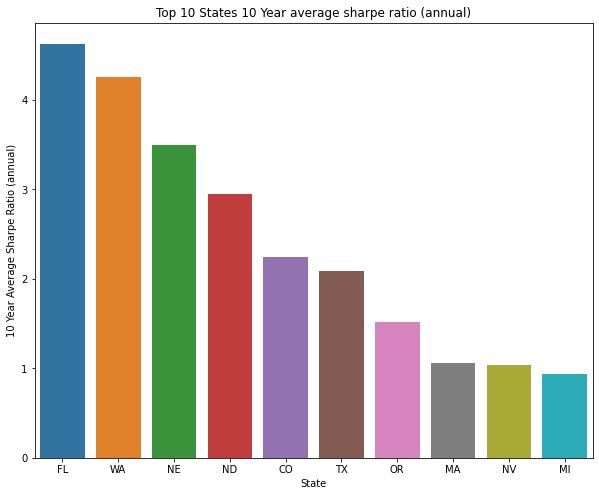

In [18]:
sns.barplot(x='state',y='10yr_average_y',data=state_averages.sort_values('10yr_average_y',ascending=False).head(10))
plt.title('Top 10 States 10 Year average sharpe ratio (annual)')
plt.xlabel('State')
plt.ylabel('10 Year Average Sharpe Ratio (annual)')

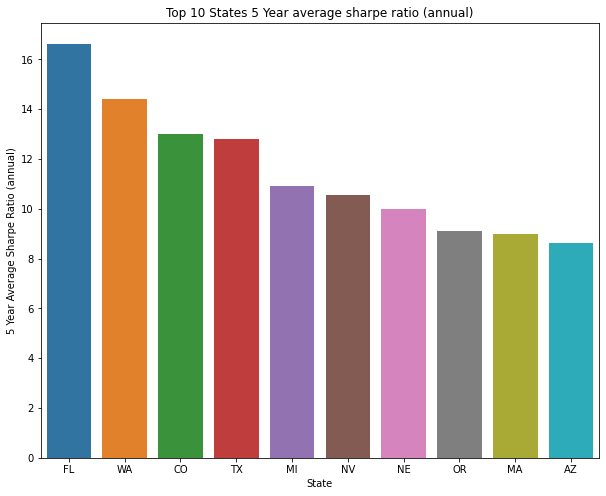

In [19]:
sns.barplot(x='state',y='5yr_average_y',data=state_averages.sort_values('5yr_average_y',ascending=False).head(10))
plt.title('Top 10 States 5 Year average sharpe ratio (annual)')
plt.xlabel('State')
plt.ylabel('5 Year Average Sharpe Ratio (annual)')
plt.savefig('images/states_barplot')

In [20]:
st10 = list(state_averages.sort_values('10yr_average_y',ascending=False).state.head(10))
st5 = list(state_averages.sort_values('5yr_average_y',ascending=False).state.head(10))
st3 = list(state_averages.sort_values('3yr_average_y',ascending=False).state.head(10))
st1 = list(state_averages.sort_values('1yr_average_y',ascending=False).state.head(10))

Text(0.5, 1.0, 'Top 10 States by 10 year Sharpe Ratio (annual)')

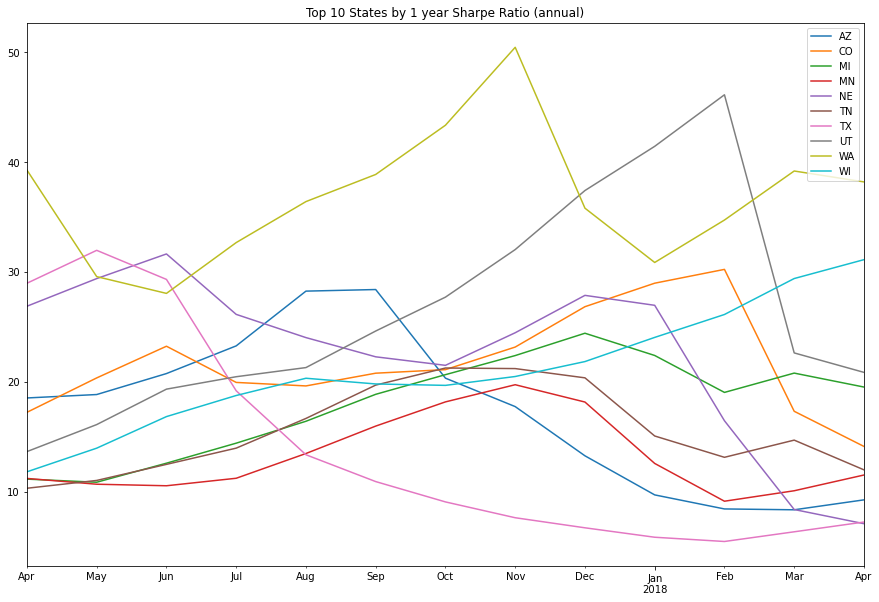

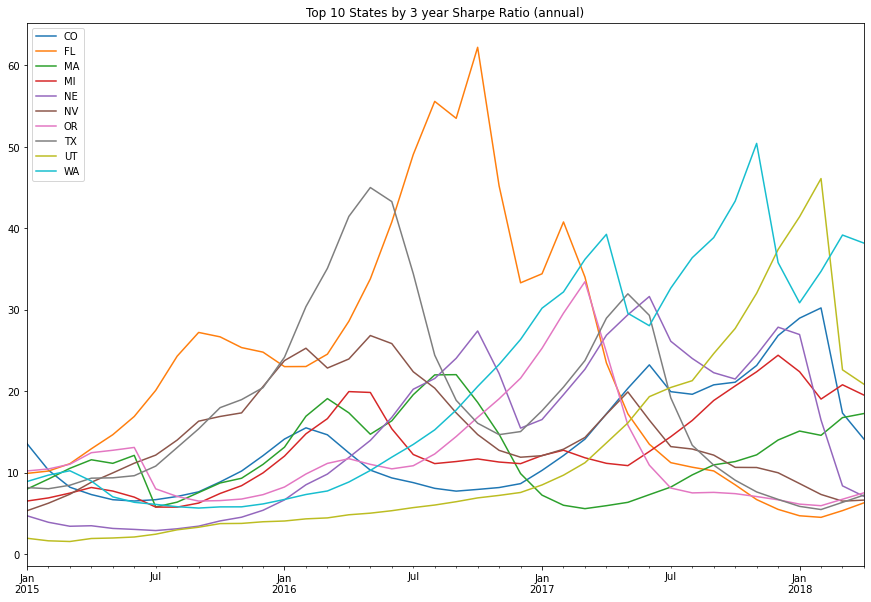

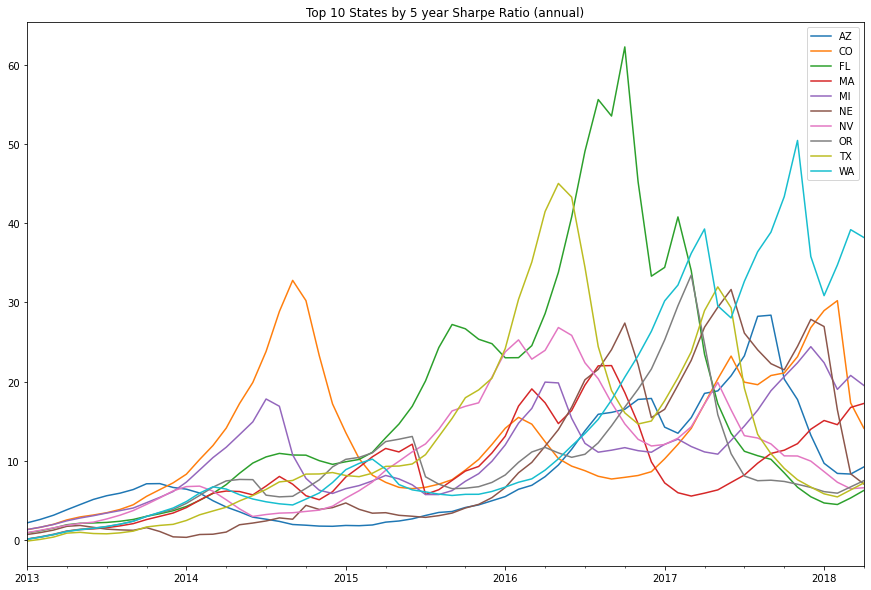

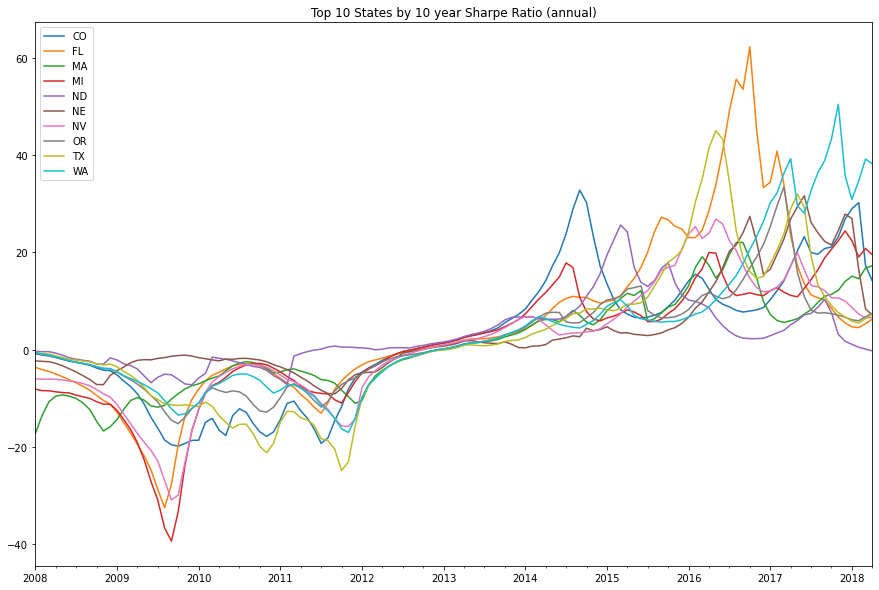

In [21]:
fig1, ax1 = plt.subplots(figsize=(15,10))
for state_df in state_dfs:
    for x in st1:
        if x in state_df.columns[0]:
            state_df['2017-04-01':'2018'].sharpe_ratio_annual.plot(label=state_df.columns[0],ax=ax1)
        else: continue
plt.legend()
plt.title('Top 10 States by 1 year Sharpe Ratio (annual)')

fig, ax = plt.subplots(figsize=(15,10))
for state_df in state_dfs:
    for x in st3:
        if x in state_df.columns[0]:
            state_df['2015':].sharpe_ratio_annual.plot(label=state_df.columns[0])
        else: continue
plt.legend()
plt.title('Top 10 States by 3 year Sharpe Ratio (annual)')



fig2, ax2 = plt.subplots(figsize=(15,10))
for state_df in state_dfs:
    for x in st5:
        if x in state_df.columns[0]:
            state_df['2013':'2018'].sharpe_ratio_annual.plot(label=state_df.columns[0],ax=ax2)
        else: continue
plt.legend()
plt.title('Top 10 States by 5 year Sharpe Ratio (annual)')

fig3, ax3 = plt.subplots(figsize=(15,10))
for state_df in state_dfs:
    for x in st10:
        if x in state_df.columns[0]:
            state_df['2008':'2018'].sharpe_ratio_annual.plot(label=state_df.columns[0],ax=ax3)
        else: continue
plt.legend()
plt.title('Top 10 States by 10 year Sharpe Ratio (annual)')

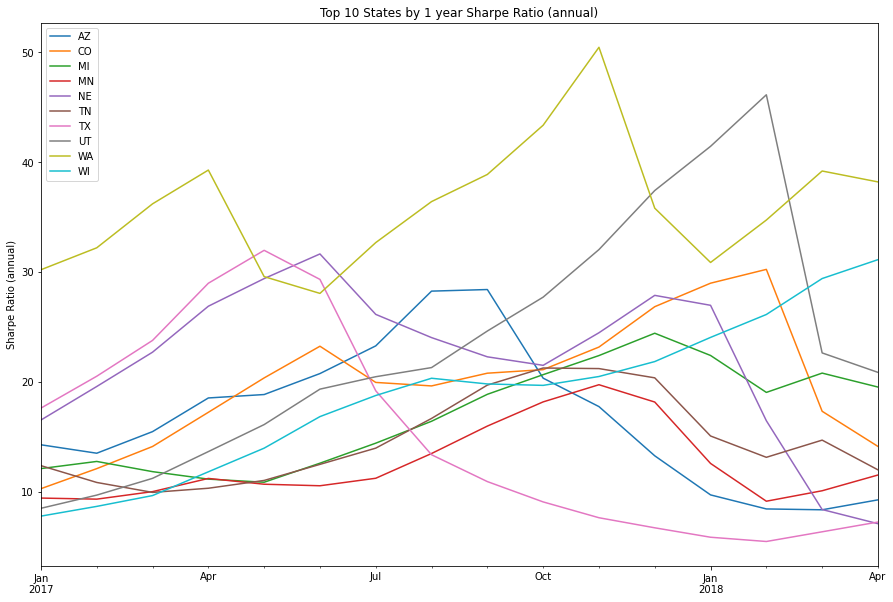

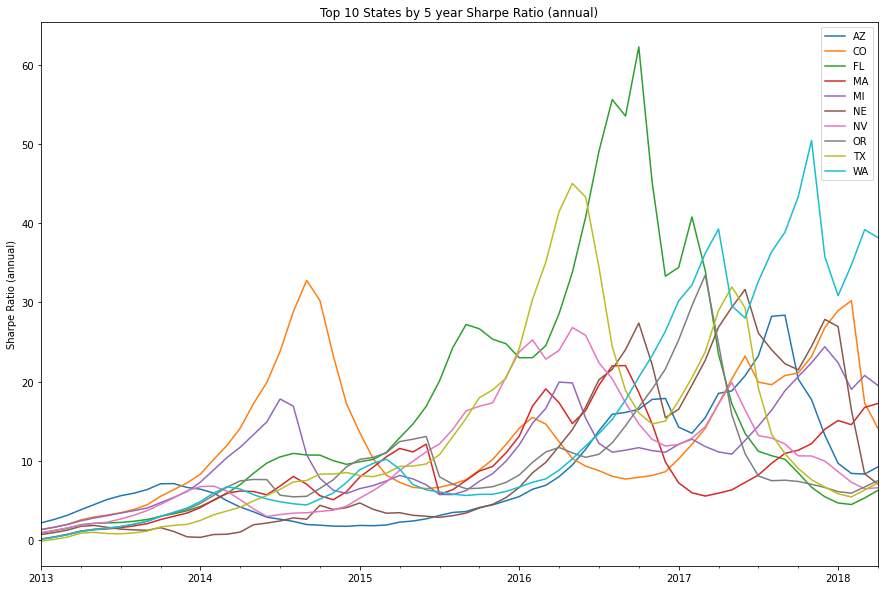

In [22]:
fig1, ax1 = plt.subplots(figsize=(15,10))
for state_df in state_dfs:
    for x in st1:
        if x in state_df.columns[0]:
            state_df['2017':'2018'].sharpe_ratio_annual.plot(label=state_df.columns[0],ax=ax1)
        else: continue
plt.legend()
plt.ylabel("Sharpe Ratio (annual)")
plt.title('Top 10 States by 1 year Sharpe Ratio (annual)')
plt.savefig('images/top_states_eda_1')

fig2, ax2 = plt.subplots(figsize=(15,10))
for state_df in state_dfs:
    for x in st5:
        if x in state_df.columns[0]:
            state_df['2013':'2018'].sharpe_ratio_annual.plot(label=state_df.columns[0],ax=ax2)
        else: continue
plt.legend()
plt.ylabel("Sharpe Ratio (annual)")
plt.title('Top 10 States by 5 year Sharpe Ratio (annual)')
plt.savefig('images/top_states_eda_5')

Looking through the above plots, I've determinded to include the states that are in both the top 10 states for the 1 year average sharpe ratio and 5 year average sharpe ratio which comes to out to 14 states.

Top states on my watchlist are WA and WI looking through the 1 year period of SR, and looking through 5 year avg SR CO and WA.

To note, many looking solely at the state level does average up or down an influence of a particular state so I intend to keep a relatively wide net when moving to county level hence the rational for the selection of states above

In [23]:
top_states = set(st5 + st1)
top_states

{'AZ',
 'CO',
 'FL',
 'MA',
 'MI',
 'MN',
 'NE',
 'NV',
 'OR',
 'TN',
 'TX',
 'UT',
 'WA',
 'WI'}

### Exploring Counties

In [24]:
counties = df.loc[df['State'].isin(top_states)].drop(columns=['RegionID','City', 'RegionName', 'Metro', 'State','SizeRank'],
                                           axis=1).groupby('CountyName').mean()
counties = pd.DataFrame(counties.reset_index())
county_columns = list(counties.T.iloc[0])
counties = counties.T
counties.columns = county_columns
counties = counties[1:]
counties = counties.set_index(pd.to_datetime(counties.index))
counties = counties.applymap(lambda x: round(np.float(x),2))

In [25]:
counties.head()

,Adams,Alachua,Alamosa,Allegan,Anderson,Angelina,Anoka,Aransas,Arapahoe,Archer,...,Wise,Wood,Worcester,Wright,Yakima,Yamhill,Yavapai,Yoakum,Young,Yuma
1996-04-01,123260.00,81400.00,52100.0,73466.67,62812.5,56300.0,90583.33,92300.0,137573.68,47400.0,...,NaN,91383.33,127142.86,106057.14,89800.00,100350.0,94923.53,NaN,55600.0,75760.0
1996-05-01,123593.33,81141.67,52400.0,73925.00,63062.5,56400.0,91216.67,92400.0,137821.05,47450.0,...,NaN,90900.00,127621.43,105542.86,90278.57,100900.0,94858.82,NaN,55500.0,76460.0
1996-06-01,123953.33,80866.67,52600.0,74400.00,63300.0,56500.0,91800.00,92500.0,138105.26,47500.0,...,NaN,90350.00,128084.29,104985.71,90700.00,101450.0,94788.24,NaN,55500.0,77080.0
1996-07-01,124320.00,80633.33,52800.0,74883.33,63550.0,56700.0,92391.67,92600.0,138347.37,47500.0,...,NaN,89716.67,128521.43,104307.14,91128.57,102010.0,94776.47,NaN,55400.0,77620.0
1996-08-01,124726.67,80441.67,53000.0,75358.33,63787.5,56900.0,92966.67,92800.0,138642.11,47550.0,...,NaN,89066.67,128921.43,103585.71,91492.86,102580.0,94835.29,NaN,55300.0,78160.0


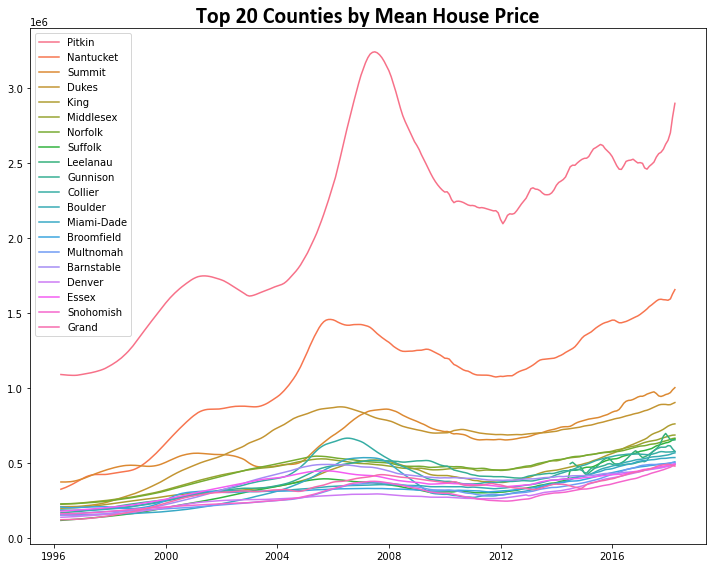

In [26]:
#Now looking at top 20 counties by mean home price as of 2018
top20counties = list(counties.iloc[-1,:].sort_values(ascending=False).head(20).index)
font = {'family' : 'Calibri',
        'weight' : 'bold',
        'size'   : 22}
rcParams['figure.figsize'] = 10,8
sns.lineplot(data=counties[top20counties],dashes=False)
plt.title('Top 20 Counties by Mean House Price',font=font)
plt.tight_layout()

In [27]:
county_list = list(counties.columns)

In [28]:
county_dfs = []
for x in county_list:
    x = pd.DataFrame(data = counties[x],)
    county_dfs.append(x)

In [29]:
county_dfs

[                Adams
 1996-04-01  123260.00
 1996-05-01  123593.33
 1996-06-01  123953.33
 1996-07-01  124320.00
 1996-08-01  124726.67
 ...               ...
 2017-12-01  345260.00
 2018-01-01  348413.33
 2018-02-01  351440.00
 2018-03-01  355440.00
 2018-04-01  358220.00
 
 [265 rows x 1 columns],
               Alachua
 1996-04-01   81400.00
 1996-05-01   81141.67
 1996-06-01   80866.67
 1996-07-01   80633.33
 1996-08-01   80441.67
 ...               ...
 2017-12-01  189791.67
 2018-01-01  190883.33
 2018-02-01  192700.00
 2018-03-01  195341.67
 2018-04-01  197416.67
 
 [265 rows x 1 columns],
              Alamosa
 1996-04-01   52100.0
 1996-05-01   52400.0
 1996-06-01   52600.0
 1996-07-01   52800.0
 1996-08-01   53000.0
 ...              ...
 2017-12-01  157500.0
 2018-01-01  157200.0
 2018-02-01  156800.0
 2018-03-01  156400.0
 2018-04-01  155800.0
 
 [265 rows x 1 columns],
               Allegan
 1996-04-01   73466.67
 1996-05-01   73925.00
 1996-06-01   74400.00
 1996-07-01

In [30]:
for county_df in county_dfs:
    county_df['ROI_MoM'] = np.zeros((265))
    county_df['ROI_YoY'] = np.zeros((265))
    for x in range(0,265):    
        if x + 1 <265:
            county_df.iloc[x+1,1] = round((county_df.iloc[x+1,0] - county_df.iloc[x,0])/county_df.iloc[x,0],4)
        else: break
    for x in range(0,265):    
        if x + 12 <265:
            county_df.iloc[x+12,2] = round((county_df.iloc[x+12,0] - county_df.iloc[x,0])/county_df.iloc[x,0],4)
        else: break
    county_df['EMA_6MO_roi_mo'] = county_df.ROI_MoM.ewm(span=6,adjust=False).mean()
    county_df['EMA_6MO_std_mo'] = county_df.ROI_MoM.ewm(span=6,adjust=False).std()
    county_df['EMA_6MO_roi_y'] = county_df.ROI_YoY.ewm(span=6,adjust=False).mean()
    county_df['EMA_6MO_std_y'] = county_df.ROI_YoY.ewm(span=6,adjust=False).std()
    county_df['rfr'] = rfr.DGS10
    county_df['sharpe_ratio_monthly'] = (county_df['EMA_6MO_roi_mo'] - (county_df.rfr/12))/county_df['EMA_6MO_std_mo']
    county_df['sharpe_ratio_annual'] = (county_df['EMA_6MO_roi_y'] - (county_df.rfr))/county_df['EMA_6MO_std_y']

In [31]:
ct = []
avg_5_mo = []
avg_5_y = []
avg_10_mo = []
avg_10_y= []
avg_1_mo =[]
avg_1_y=[]
avg_3_mo = []
avg_3_y = []
for county in county_dfs:
    ct.append(county.columns[0])
    avg_1_mo.append(county['2017-04-01':].sharpe_ratio_monthly.mean())
    avg_1_y.append(county['2017-04-01':].sharpe_ratio_annual.mean())
    avg_5_mo.append(county['2013':'2018'].sharpe_ratio_monthly.mean())
    avg_5_y.append(county['2013':'2018'].sharpe_ratio_annual.mean())
    avg_10_mo.append(county['2008':'2018'].sharpe_ratio_monthly.mean())
    avg_10_y.append(county['2008':'2018'].sharpe_ratio_annual.mean())
    avg_3_mo.append(county['2015-04-01':].sharpe_ratio_monthly.mean())
    avg_3_y.append(county['2015-04-01':].sharpe_ratio_annual.mean())
county_averages = pd.concat([pd.DataFrame(ct,dtype='str'),pd.DataFrame(avg_1_mo,dtype=float),pd.DataFrame(avg_1_y,dtype=float),
                            pd.DataFrame(avg_3_mo,dtype=float),pd.DataFrame(avg_3_y,dtype=float),
                            pd.DataFrame(avg_5_mo,dtype=float),pd.DataFrame(avg_5_y,dtype=float),
                                pd.DataFrame(avg_10_mo,dtype=float),pd.DataFrame(avg_10_y,dtype=float)],axis=1)
county_averages.columns = ['county','1yr_average_mo','1yr_average_y',
                          '3yr_average_mo','3yr_average_y',
                          '5yr_average_mo','5yr_average_y',
                          '10yr_average_mo','10yr_average_y']


In [32]:
## no duplicate counties
county_averages.county.duplicated().sum()

0

In [33]:
ct10 = list(county_averages.sort_values('10yr_average_mo',ascending=False).county.head(20))
ct5 = list(county_averages.sort_values('5yr_average_mo',ascending=False).county.head(20))
ct3 = list(county_averages.sort_values('3yr_average_mo',ascending=False).county.head(20))
ct1 = list(county_averages.sort_values('1yr_average_mo',ascending=False).county.head(20))

Text(0.5, 1.0, 'Top 10 Counties by 10 year Sharpe Ratio (annual)')

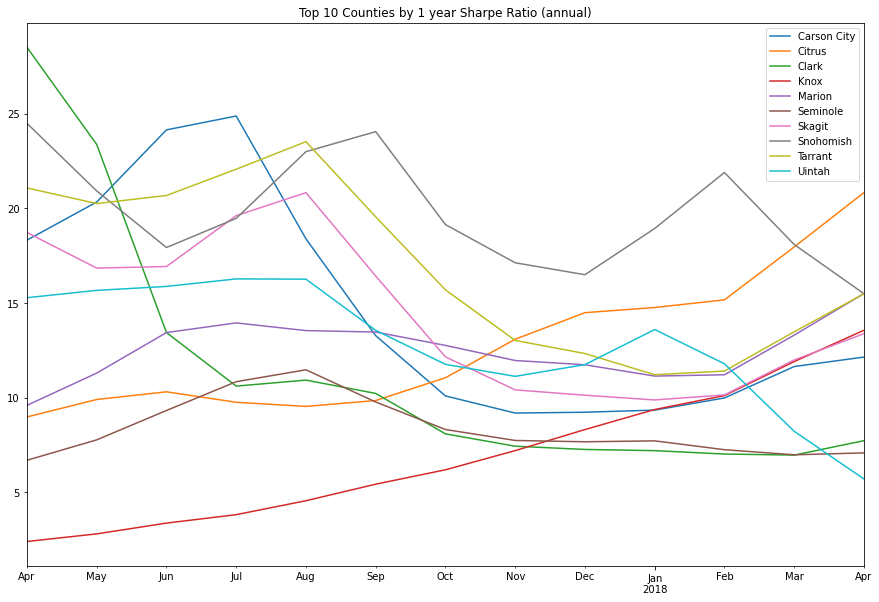

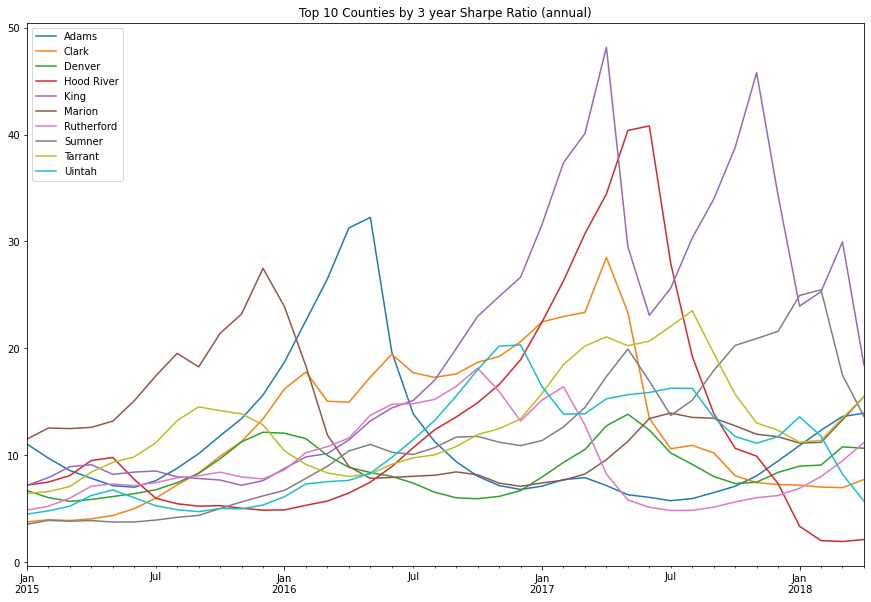

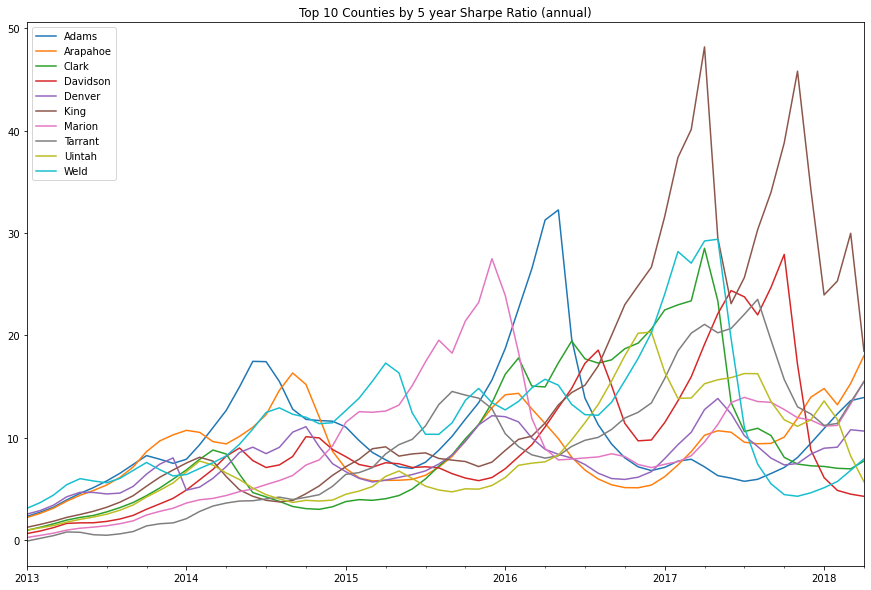

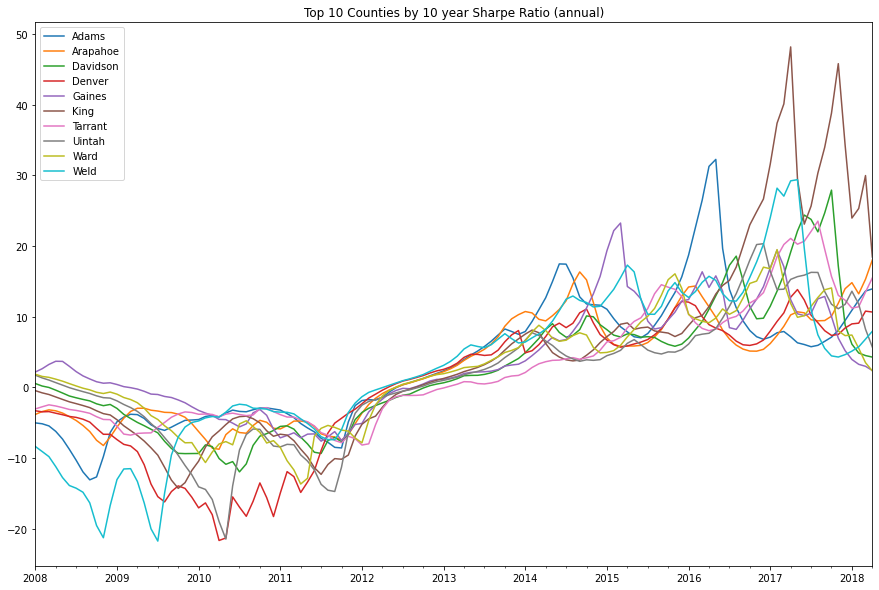

In [34]:
fig1, ax1 = plt.subplots(figsize=(15,10))
for county_df in county_dfs:
    for x in ct1[:10]:
        if x == county_df.columns[0]:
            county_df['2017-04-01':'2018'].sharpe_ratio_annual.plot(label=county_df.columns[0],ax=ax1)
        else: continue
plt.legend()
plt.title('Top 10 Counties by 1 year Sharpe Ratio (annual)')
plt.savefig('images/county_1yr_graph')

fig, ax = plt.subplots(figsize=(15,10))
for county_df in county_dfs:
    for x in ct3[:10]:
        if x == county_df.columns[0]:
            county_df['2015':].sharpe_ratio_annual.plot(label=county_df.columns[0],ax=ax)
        else: continue
plt.legend()
plt.title('Top 10 Counties by 3 year Sharpe Ratio (annual)')



fig2, ax2 = plt.subplots(figsize=(15,10))
for county_df in county_dfs:
    for x in ct5[:10]:
        if x == county_df.columns[0]:
            county_df['2013':'2018'].sharpe_ratio_annual.plot(label=county_df.columns[0],ax=ax2)
        else: continue
plt.legend()
plt.title('Top 10 Counties by 5 year Sharpe Ratio (annual)')
plt.savefig('images/county_5yr_graph')

fig3, ax3 = plt.subplots(figsize=(15,10))
for county_df in county_dfs:
    for x in ct10[:10]:
        if x == county_df.columns[0]:
            county_df['2008':'2018'].sharpe_ratio_annual.plot(label=county_df.columns[0],ax=ax3)
        else: continue
plt.legend()
plt.title('Top 10 Counties by 10 year Sharpe Ratio (annual)')

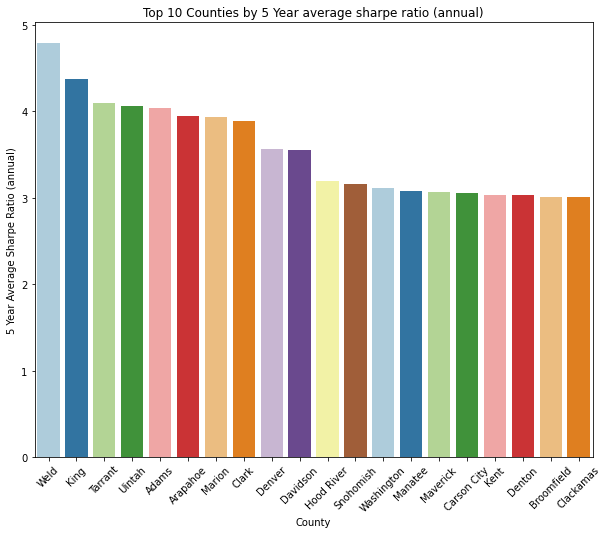

In [35]:
sns.barplot(x='county',y='5yr_average_mo',palette='Paired',data=county_averages.sort_values('5yr_average_mo',ascending=False).head(20))
plt.title('Top 10 Counties by 5 Year average sharpe ratio (annual)')
plt.xlabel('County')
plt.ylabel('5 Year Average Sharpe Ratio (annual)')
plt.xticks(rotation=45)
plt.savefig('images/county_barplot_5yr')

I made the decision here to go with determine top counties for the 1,3,5,10 year periods by using monthly SR instead of annual as when looking at counties with highest annual averages they all counties where in a downtrend and in hopes to capture upward trending counties I looked into the top monthly average sharpe counties. Even still I decided to include all cities from these states as I did not want to miss potential cities that were averaged out of by other cities in a county being low performing.

Separately, I do note potential interest in Araphoe, Weld, Tarrant, and King (even though downtrending) counties as being potential candidates given by their high average sharpe ratios and uptrending graphs.

### Exploring Cities

In [36]:
cities = df.loc[df['State'].isin(top_states)].drop(columns=['RegionID','CountyName', 'RegionName', 'Metro', 'State','SizeRank'],
                                           axis=1).groupby('City').mean()
cities = pd.DataFrame(cities.reset_index())
city_columns = list(cities.T.iloc[0])
cities = cities.T
cities.columns = city_columns
cities = cities[1:]
cities = cities.set_index(pd.to_datetime(cities.index))
cities = cities.applymap(lambda x: round(np.float(x),2))

In [37]:
cities.head()

,Aberdeen,Abilene,Abington,Acton,Acushnet,Adams,Adamsville,Addison,Afton,Agawam,...,Ypsilanti,Yulee,Yuma,Zeeland,Zephyr Cove,Zephyrhills,Zillah,Zimmerman,Zumbro Falls,Zumbrota
1996-04-01,86600.0,63440.0,135100.0,265500.0,110200.0,101850.0,33200.0,157000.0,186100.0,117400.0,...,129200.0,74500.0,79466.67,116400.0,NaN,68133.33,98300.0,89600.0,103500.0,88500.0
1996-05-01,86300.0,63400.0,135100.0,265700.0,109900.0,101700.0,33400.0,157250.0,186500.0,117150.0,...,129800.0,74100.0,80033.33,116600.0,NaN,68266.67,98800.0,87800.0,103900.0,88300.0
1996-06-01,86100.0,63360.0,135100.0,265800.0,109600.0,101500.0,33500.0,157500.0,186800.0,116900.0,...,130400.0,73700.0,80533.33,116800.0,NaN,68400.00,99200.0,86200.0,104200.0,88000.0
1996-07-01,85900.0,63340.0,135000.0,266000.0,109400.0,101200.0,33600.0,157750.0,187100.0,116650.0,...,131100.0,73100.0,80966.67,117000.0,NaN,68500.00,99500.0,84700.0,104400.0,87700.0
1996-08-01,85700.0,63380.0,135000.0,266200.0,109200.0,100900.0,33800.0,158000.0,187500.0,116450.0,...,131700.0,72500.0,81366.67,117300.0,NaN,68600.00,99800.0,83500.0,104600.0,87400.0


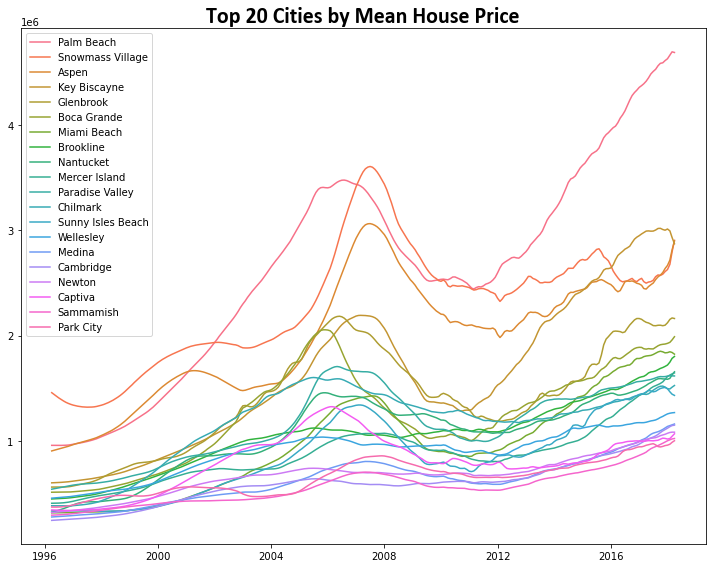

In [38]:
top20cities = list(cities.iloc[-1,:].sort_values(ascending=False).head(20).index)
font = {'family' : 'Calibri',
        'weight' : 'bold',
        'size'   : 22}
rcParams['figure.figsize'] = 10,8
sns.lineplot(data=cities[top20cities],dashes=False)
plt.title('Top 20 Cities by Mean House Price',font=font)
plt.tight_layout()

In [39]:
city_list = list(cities.columns)
len(city_list)

2915

In [40]:
city_dfs = []
for x in city_list:
    x = pd.DataFrame(data = cities[x])
    city_dfs.append(x)

In [ ]:
for city_df in city_dfs:
    city_df['ROI_MoM'] = np.zeros((265))
    city_df['ROI_YoY'] = np.zeros((265))
    for x in range(0,265):    
        if x + 1 <265:
            city_df.iloc[x+1,1] = round((city_df.iloc[x+1,0] - city_df.iloc[x,0])/city_df.iloc[x,0],4)
        else: break
    for x in range(0,265):    
        if x + 12 <265:
            city_df.iloc[x+12,2] = round((city_df.iloc[x+12,0] - city_df.iloc[x,0])/city_df.iloc[x,0],4)
        else: break
    city_df['EMA_6MO_roi_mo'] = city_df.ROI_MoM.ewm(span=6,adjust=False).mean()
    city_df['EMA_6MO_std_mo'] = city_df.ROI_MoM.ewm(span=6,adjust=False).std()
    city_df['EMA_6MO_roi_y'] = city_df.ROI_YoY.ewm(span=6,adjust=False).mean()
    city_df['EMA_6MO_std_y'] = city_df.ROI_YoY.ewm(span=6,adjust=False).std()
    city_df['rfr'] = rfr.DGS10
    city_df['sharpe_ratio_monthly'] = (city_df['EMA_6MO_roi_mo'] - (city_df.rfr/12))/city_df['EMA_6MO_std_mo']
    city_df['sharpe_ratio_annual'] = (city_df['EMA_6MO_roi_y'] - (city_df.rfr))/city_df['EMA_6MO_std_y']

In [ ]:
cty = list(cities.columns)
avg_5_mo = []
avg_5_y = []
avg_10_mo = []
avg_10_y= []
avg_1_mo =[]
avg_1_y=[]
avg_3_mo = []
avg_3_y = []
for city in city_dfs:
    avg_1_mo.append(city['2017-04-01':].sharpe_ratio_monthly.mean())
    avg_1_y.append(city['2017-04-01':].sharpe_ratio_annual.mean())
    avg_5_mo.append(city['2013':'2018'].sharpe_ratio_monthly.mean())
    avg_5_y.append(city['2013':'2018'].sharpe_ratio_annual.mean())
    avg_10_mo.append(city['2008':'2018'].sharpe_ratio_monthly.mean())
    avg_10_y.append(city['2008':'2018'].sharpe_ratio_annual.mean())
    avg_3_mo.append(city['2015-04-01':].sharpe_ratio_monthly.mean())
    avg_3_y.append(city['2015-04-01':].sharpe_ratio_annual.mean())
city_averages = pd.concat([pd.DataFrame(cty,dtype='str'),pd.DataFrame(avg_1_mo,dtype=float),pd.DataFrame(avg_1_y,dtype=float),
                            pd.DataFrame(avg_3_mo,dtype=float),pd.DataFrame(avg_3_y,dtype=float),
                            pd.DataFrame(avg_5_mo,dtype=float),pd.DataFrame(avg_5_y,dtype=float),
                                pd.DataFrame(avg_10_mo,dtype=float),pd.DataFrame(avg_10_y,dtype=float)],axis=1)
city_averages.columns = ['city','1yr_average_mo','1yr_average_y',
                          '3yr_average_mo','3yr_average_y',
                          '5yr_average_mo','5yr_average_y',
                          '10yr_average_mo','10yr_average_y']

In [ ]:
cty10 = list(city_averages.sort_values('10yr_average_mo',ascending=False).city.head(25))
cty5 = list(city_averages.sort_values('5yr_average_mo',ascending=False).city.head(25))
cty3 =list(city_averages.sort_values('3yr_average_mo',ascending=False).city.head(25))
cty1 =list(city_averages.sort_values('1yr_average_mo',ascending=False).city.head(25))

In [ ]:
cty10 = list(city_averages.sort_values('10yr_average_mo',ascending=False).city.head(20))
cty5 = list(city_averages.sort_values('5yr_average_mo',ascending=False).city.head(20))
cty3 =list(city_averages.sort_values('3yr_average_mo',ascending=False).city.head(20))
cty1 =list(city_averages.sort_values('1yr_average_mo',ascending=False).city.head(20))

In [ ]:
fig1, ax1 = plt.subplots(figsize=(18,10))
for city_df in city_dfs:
    for x in cty1[:10]:
        if x == city_df.columns[0]:
            city_df['2017-04-01':'2018'].sharpe_ratio_annual.plot(label=city_df.columns[0],ax=ax1,)
        else: continue
plt.legend()
plt.title('Top 10 Cities by 1 year Sharpe Ratio (annual)')

fig, ax = plt.subplots(figsize=(18,10))
for city_df in city_dfs:
    for x in cty3[:10]:
        if x == city_df.columns[0]:
            city_df['2015':].sharpe_ratio_annual.plot(label=city_df.columns[0],ax=ax)
        else: continue
plt.legend()
plt.title('Top 10 Cities by 3 year Sharpe Ratio (annual)')



fig2, ax2 = plt.subplots(figsize=(18,10))
for city_df in city_dfs:
    for x in cty5[:10]:
        if x == city_df.columns[0]:
            city_df['2013':'2018'].sharpe_ratio_annual.plot(label=city_df.columns[0],ax=ax2)
        else: continue
plt.legend()
plt.title('Top 10 Cities by 5 year Sharpe Ratio (annual)')

fig3, ax3 = plt.subplots(figsize=(18,10))
for city_df in city_dfs:
    for x in cty10[:10]:
        if x == city_df.columns[0]:
            city_df['2008':'2018'].sharpe_ratio_annual.plot(label=city_df.columns[0],ax=ax3)
        else: continue
plt.legend()
plt.title('Top 10 Cities by 10 year Sharpe Ratio (annual)')

In [ ]:
fig1, ax1 = plt.subplots(figsize=(18,10))
for city_df in city_dfs:
    for x in cty1[-10:]:
        if x == city_df.columns[0]:
            city_df['2017-04-01':'2018'].sharpe_ratio_annual.plot(label=city_df.columns[0],ax=ax1,)
        else: continue
plt.legend()
plt.title('Rank 10-20 Cities by 1 year Sharpe Ratio (annual)')

fig, ax = plt.subplots(figsize=(18,10))
for city_df in city_dfs:
    for x in cty3[-10:]:
        if x == city_df.columns[0]:
            city_df['2015':].sharpe_ratio_annual.plot(label=city_df.columns[0],ax=ax)
        else: continue
plt.legend()
plt.title('Rank 10-20 Cities by 3 year Sharpe Ratio (annual)')



fig2, ax2 = plt.subplots(figsize=(18,10))
for city_df in city_dfs:
    for x in cty5[-10:]:
        if x == city_df.columns[0]:
            city_df['2013':'2018'].sharpe_ratio_annual.plot(label=city_df.columns[0],ax=ax2)
        else: continue
plt.legend()
plt.title('Rank 10-20 Cities by 5 year Sharpe Ratio (annual)')

fig3, ax3 = plt.subplots(figsize=(18,10))
for city_df in city_dfs:
    for x in cty10[-10:]:
        if x == city_df.columns[0]:
            city_df['2008':'2018'].sharpe_ratio_annual.plot(label=city_df.columns[0],ax=ax3)
        else: continue
plt.legend()
plt.title('Rank 10-20 Cities by 10 year Sharpe Ratio (annual)')

In [ ]:
df.loc[df['City'].isin(ft)].drop(columns=['RegionID','CountyName', 'RegionName', 'Metro', 'State','SizeRank'],
                                           axis=1).groupby('City').mean()

Above we have the top 20 cities on 2 sets of plots for the 1,3,5,10 year periods. The cities included for each time period are determined by the cities with the top average SR for those respective periods.

Final cities I will be looking for zipcodes in are Aurora, Greeley, Lakewood, Fort Worth, Everett, Sky Lake, Rochester, and Grand Rapids. These cities include a blend of reasons to invest. Aurora and Greeley have some of the highest Sharpe ratios in both the 1 and 5 year time periods and are trending up in the 1 year period

Fort Worth and Sky Lake have extremely high Sharpe Ratio for the most recent 1 year period. Their longer term averages are lower than the other cities but that to me points to higher future potential return given these cities are not at extended prices yet relative to others i.e. average home price as of 2018 are both around 180k

Rochester and Everett are high performing cities across time periods and trending up.

Lastly, Grand Rapds had high averages but is downward trending. I added it to the list to see if perhaps there are select zipcodes within the city that are trending up and for diversification purposes


In [ ]:
final_cities = ['Aurora','Greeley','Lakewood','Fort Worth','Everett','Sky Lake','Rochester','Grand Rapids']

In [ ]:
fig2, ax2 = plt.subplots(figsize=(18,10))
for city_df in city_dfs:
    for x in final_cities:
        if x == city_df.columns[0]:
            city_df['2013':'2018'].sharpe_ratio_annual.plot(label=city_df.columns[0],ax=ax2)
        else: continue
plt.legend()
plt.title('Final Cities by 5 year Sharpe Ratio (annual)')
plt.ylabel('Sharp Ratio')
plt.savefig('images/finalcities_sharp')


### Exploring Zipcodes of top cities

In [ ]:
zips = df.loc[df['City'].isin(final_cities)].drop(columns=['RegionID','City', 'CountyName', 'Metro', 'State','SizeRank'],
                                           axis=1).groupby('RegionName').mean()
zips = pd.DataFrame(zips.reset_index())
zip_columns = list(zips.T.iloc[0])
zips = zips.T
zips.columns = zip_columns
zips = zips[1:]
zips = zips.set_index(pd.to_datetime(zips.index))
zips = zips.applymap(lambda x: round(np.float(x),2))

In [ ]:
top20zips = list(zips.iloc[-1,:].sort_values(ascending=False).head(20).index)
font = {'family' : 'Calibri',
        'weight' : 'bold',
        'size'   : 22}
rcParams['figure.figsize'] = 10,8
sns.lineplot(data=zips[top20zips],dashes=False)
plt.title('Top 20 zipcodes by Mean House Price',font=font)
plt.tight_layout()

In [ ]:
zip_list = list(zips.columns)
len(zip_list)

In [ ]:
zip_dfs = []
for x in zip_list:
    x = pd.DataFrame(data = zips[x])
    zip_dfs.append(x)

In [ ]:
for zip_df in zip_dfs:
    zip_df['ROI_MoM'] = np.zeros((265))
    zip_df['ROI_YoY'] = np.zeros((265))
    for x in range(0,265):    
        if x + 1 <265:
            zip_df.iloc[x+1,1] = round((zip_df.iloc[x+1,0] - zip_df.iloc[x,0])/zip_df.iloc[x,0],4)
        else: break
    for x in range(0,265):    
        if x + 12 <265:
            zip_df.iloc[x+12,2] = round((zip_df.iloc[x+12,0] - zip_df.iloc[x,0])/zip_df.iloc[x,0],4)
        else: break
    zip_df['EMA_6MO_roi_mo'] = zip_df.ROI_MoM.ewm(span=6,adjust=False).mean()
    zip_df['EMA_6MO_std_mo'] = zip_df.ROI_MoM.ewm(span=6,adjust=False).std()
    zip_df['EMA_6MO_roi_y'] = zip_df.ROI_YoY.ewm(span=6,adjust=False).mean()
    zip_df['EMA_6MO_std_y'] = zip_df.ROI_YoY.ewm(span=6,adjust=False).std()
    zip_df['rfr'] = rfr.DGS10
    zip_df['sharpe_ratio_monthly'] = (zip_df['EMA_6MO_roi_mo'] - (zip_df.rfr/12))/zip_df['EMA_6MO_std_mo']
    zip_df['sharpe_ratio_annual'] = (zip_df['EMA_6MO_roi_y'] - (zip_df.rfr))/zip_df['EMA_6MO_std_y']

In [ ]:
avg_5_mo = []
avg_5_y = []
avg_10_mo = []
avg_10_y= []
avg_1_mo =[]
avg_1_y=[]
avg_3_mo = []
avg_3_y = []
last_mo = []
for zip_ in zip_dfs:
    avg_1_mo.append(zip_['2017-04-01':].sharpe_ratio_monthly.mean())
    avg_1_y.append(zip_['2017-04-01':].sharpe_ratio_annual.mean())
    avg_5_mo.append(zip_['2013':'2018'].sharpe_ratio_monthly.mean())
    avg_5_y.append(zip_['2013':'2018'].sharpe_ratio_annual.mean())
    avg_10_mo.append(zip_['2008':'2018'].sharpe_ratio_monthly.mean())
    avg_10_y.append(zip_['2008':'2018'].sharpe_ratio_annual.mean())
    avg_3_mo.append(zip_['2015-04-01':].sharpe_ratio_monthly.mean())
    avg_3_y.append(zip_['2015-04-01':].sharpe_ratio_annual.mean())
    last_mo.append(zip_['2018-04'].sharpe_ratio_annual.mean())
zip_averages = pd.concat([pd.DataFrame(zip_list,dtype='str'),pd.DataFrame(avg_1_mo,dtype=float),pd.DataFrame(avg_1_y,dtype=float),
                            pd.DataFrame(avg_3_mo,dtype=float),pd.DataFrame(avg_3_y,dtype=float),
                            pd.DataFrame(avg_5_mo,dtype=float),pd.DataFrame(avg_5_y,dtype=float),
                            pd.DataFrame(avg_10_mo,dtype=float),pd.DataFrame(avg_10_y,dtype=float),
                            pd.DataFrame(last_mo)],axis=1)
zip_averages.columns = ['zipcode','1yr_average_mo','1yr_average_y',
                          '3yr_average_mo','3yr_average_y',
                          '5yr_average_mo','5yr_average_y',
                          '10yr_average_mo','10yr_average_y','last_month']

In [ ]:
zip10 = (np.array(zip_averages.sort_values('10yr_average_mo',ascending=False).zipcode.head(30))).astype(np.float)
zip5 = (np.array(zip_averages.sort_values('5yr_average_mo',ascending=False).zipcode.head(30))).astype(np.float)
zip3 =(np.array(zip_averages.sort_values('3yr_average_mo',ascending=False).zipcode.head(30))).astype(np.float)
zip1 =(np.array(zip_averages.sort_values('1yr_average_mo',ascending=False).zipcode.head(30))).astype(np.float)

In [ ]:
fig1, ax1 = plt.subplots(figsize=(18,10))
for zip_df in zip_dfs:
    for x in zip1[:15]:
        if x == zip_df.columns[0]:
            zip_df['2017-04-01':'2018'].sharpe_ratio_annual.plot(label=zip_df.columns[0],ax=ax1,)
        else: continue
plt.legend()
plt.title('Top 15 Zipcodes by 1 year Sharpe Ratio (annual)')

fig, ax = plt.subplots(figsize=(18,10))
for zip_df in zip_dfs:
    for x in zip3[:15]:
        if x == zip_df.columns[0]:
            zip_df['2015':].sharpe_ratio_annual.plot(label=zip_df.columns[0],ax=ax)
        else: continue
plt.legend()
plt.title('Top 15 Zipcodes by 3 year Sharpe Ratio (annual)')



fig2, ax2 = plt.subplots(figsize=(18,10))
for zip_df in zip_dfs:
    for x in zip5[:15]:
        if x == zip_df.columns[0]:
            zip_df['2013':].sharpe_ratio_annual.plot(label=zip_df.columns[0],ax=ax2)
        else: continue
plt.legend()
plt.title('Top 15 Zipcodes by 5 year Sharpe Ratio (annual)')

fig3, ax3 = plt.subplots(figsize=(18,10))
for zip_df in zip_dfs:
    for x in zip10[:15]:
        if x == zip_df.columns[0]:
            zip_df['2008':].sharpe_ratio_annual.plot(label=zip_df.columns[0],ax=ax3)
        else: continue
plt.legend()
plt.title('Top 15 Zipcodes by 10 year Sharpe Ratio (annual)')

In [ ]:
fig1, ax1 = plt.subplots(figsize=(18,10))
for zip_df in zip_dfs:
    for x in zip1[-15:]:
        if x == zip_df.columns[0]:
            zip_df['2017-04-01':'2018'].sharpe_ratio_annual.plot(label=zip_df.columns[0],ax=ax1,)
        else: continue
plt.legend()
plt.title('Rank 15-30 Zipcodes by 1 year Sharpe Ratio (annual)')

fig, ax = plt.subplots(figsize=(18,10))
for zip_df in zip_dfs:
    for x in zip3[-15:]:
        if x == zip_df.columns[0]:
            zip_df['2015':].sharpe_ratio_annual.plot(label=zip_df.columns[0],ax=ax)
        else: continue
plt.legend()
plt.title('Rank 15-30 Zipcodes by 3 year Sharpe Ratio (annual)')



fig2, ax2 = plt.subplots(figsize=(18,10))
for zip_df in zip_dfs:
    for x in zip5[-15:]:
        if x == zip_df.columns[0]:
            zip_df['2013':].sharpe_ratio_annual.plot(label=zip_df.columns[0],ax=ax2)
        else: continue
plt.legend()
plt.title('Rank 15-30 Zipcodes by 5 year Sharpe Ratio (annual)')

fig3, ax3 = plt.subplots(figsize=(18,10))
for zip_df in zip_dfs:
    for x in zip10[-15:]:
        if x == zip_df.columns[0]:
            zip_df['2008':].sharpe_ratio_annual.plot(label=zip_df.columns[0],ax=ax3)
        else: continue
plt.legend()
plt.title('Rank 15-30 Zipcodes by 10 year Sharpe Ratio (annual)')

In [ ]:
topzips = [32809,98203,80012,76131,49507]

In [ ]:
fig1, ax1 = plt.subplots(figsize=(18,10))
for zip_df in zip_dfs:
    for x in topzips:
        if x == zip_df.columns[0]:
            zip_df['2017-04-01':'2018'].sharpe_ratio_annual.plot(label=zip_df.columns[0],ax=ax1,)
        else: continue
plt.legend(loc=2)
plt.title('Top 5 Zipcodes 1 year Sharpe Ratio (annual)')
plt.savefig('images/zipcodes_1yr')

fig, ax = plt.subplots(figsize=(18,10))
for zip_df in zip_dfs:
    for x in topzips:
        if x == zip_df.columns[0]:
            zip_df['2015':].sharpe_ratio_annual.plot(label=zip_df.columns[0],ax=ax)
        else: continue
plt.legend()
plt.title('Top 5 Zipcodes 3 year Sharpe Ratio (annual)')



fig2, ax2 = plt.subplots(figsize=(18,10))
for zip_df in zip_dfs:
    for x in topzips:
        if x == zip_df.columns[0]:
            zip_df['2013':'2018'].sharpe_ratio_annual.plot(label=zip_df.columns[0],ax=ax2)
        else: continue
plt.legend()
plt.title('Top 5 Zipcodes 5 year Sharpe Ratio (annual)')
plt.savefig('images/zipcodes_5yr')

fig3, ax3 = plt.subplots(figsize=(18,10))
for zip_df in zip_dfs:
    for x in topzips:
        if x == zip_df.columns[0]:
            zip_df['2008':'2018'].sharpe_ratio_annual.plot(label=zip_df.columns[0],ax=ax3)
        else: continue
plt.legend()
plt.title('Top 5 Zipcodes 10 year Sharpe Ratio (annual)')

In [ ]:
fig2, ax2 = plt.subplots(figsize=(18,10))
for zip_df in zip_dfs:
    for x in topzips:
        if x == zip_df.columns[0]:
            zip_df['2013':'2018'].ROI_YoY.plot(label=zip_df.columns[0],ax=ax2)
        else: continue
plt.legend()
plt.title('Top 5 Zipcodes Annual ROI for 5 Years(annual)')
plt.savefig('images/zipcodes_5yr_ROI')